# Across-Subject Analyses
## Computational Methods in Psychology (and Neuroscience)
### Psychology 4215/7215 --- Fall 2021
By: Per B. Sederberg, PhD



# Lesson Objectives

Upon completion of this lesson, students should have learned:

1. How to read in multiple data files
2. Perform some simple data clean-up
3. Some more Pandas analysis tricks
4. Regression across subjects


# Loading in all the data

- Let's explore one subject's data and learn stuff along the way!
- Where are the data?

In [1]:
ls flanker_dat

log_flanker_s000.slog  log_flanker_s009.slog  sysinfo_s005.slog
log_flanker_s001.slog  log_flanker_s010.slog  sysinfo_s006.slog
log_flanker_s002.slog  log_flanker_s011.slog  sysinfo_s007.slog
log_flanker_s003.slog  log_flanker_s012.slog  sysinfo_s008.slog
log_flanker_s004.slog  sysinfo_s000.slog      sysinfo_s009.slog
log_flanker_s005.slog  sysinfo_s001.slog      sysinfo_s010.slog
log_flanker_s006.slog  sysinfo_s002.slog      sysinfo_s011.slog
log_flanker_s007.slog  sysinfo_s003.slog      sysinfo_s012.slog
log_flanker_s008.slog  sysinfo_s004.slog


In [2]:
from smile.log import log2dl
import numpy as np
from scipy import stats
import pandas as pd
from glob import glob
import os


## Glob?

- Allows for pattern matching for files
- Here we want to return a list of all slogs matching a specific pattern

In [3]:
# note the results are not sorted, but we can sort them after
glob('flanker_dat/log_flanker*.slog')

['flanker_dat/log_flanker_s007.slog',
 'flanker_dat/log_flanker_s002.slog',
 'flanker_dat/log_flanker_s003.slog',
 'flanker_dat/log_flanker_s010.slog',
 'flanker_dat/log_flanker_s012.slog',
 'flanker_dat/log_flanker_s008.slog',
 'flanker_dat/log_flanker_s011.slog',
 'flanker_dat/log_flanker_s001.slog',
 'flanker_dat/log_flanker_s005.slog',
 'flanker_dat/log_flanker_s000.slog',
 'flanker_dat/log_flanker_s004.slog',
 'flanker_dat/log_flanker_s009.slog',
 'flanker_dat/log_flanker_s006.slog']

## Manipulating paths with `os.path`

- Different operation systems have different ways of dealing with directories
  - Windows separate directories with `\`
  - Most others use `/`
- Python can handle processing paths for you with the `os.path` module

In [4]:
# split up the path
filepath = 'flanker_dat/log_flanker_s002.slog'
os.path.split(filepath)

('flanker_dat', 'log_flanker_s002.slog')

In [5]:
# now we need to pull of the file extension
os.path.splitext(os.path.split(filepath)[1])

('log_flanker_s002', '.slog')

In [6]:
# and finally extract the subject id with a standard string split
os.path.splitext(os.path.split(filepath)[1])[0].split('_')

['log', 'flanker', 's002']

## Custom SLOG loading function

In [10]:
# custom function to load slogs
def load_all_subj_logs(data_dir, log_file):
    # load in a list of all the subj
    subjs = [os.path.splitext(os.path.split(filepath)[1])[0].split('_')[-1]
             for filepath in glob(os.path.join(data_dir, log_file + '*.slog'))]
    subjs.sort()

    # loop over subj and their data
    all_dat = []
    for subj in subjs:
        # set the file
        log_path = os.path.join(data_dir, log_file+'_'+subj+'.slog')
        #print(log_path)

        # load the data
        try:
            all_dat.extend(log2dl(log_path, subj=subj))
        except:
            pass

    df = pd.DataFrame(all_dat)
    
    return df

## Load in all the data

In [12]:
# load the data from each task
data_dir = 'flanker_dat'
df = load_all_subj_logs(data_dir, 'log_flanker')


## Some data clean-up

In [15]:
# add in log_rt columns
df['log_rt'] = np.log(df['rt'])

# show the columns
df.columns

Index(['resp_map_left', 'resp_map_right', 'block_num', 'trial_num',
       'stim_on_time', 'stim_on_error', 'resp', 'resp_time_time',
       'resp_time_error', 'rt', 'correct', 'location_0', 'location_1',
       'log_time', 'condition', 'direction', 'stimulus', 'subj', 'log_num',
       'log_rt', 'correct_int'],
      dtype='object')

## Check Flanker Baseline Performance

- We want to calculate mean performance in the congruent trials and run a binomial test on each participant
- How can we do this efficiently with Pandas?

## Start with a `groupby`

- We know we can group rows of data by subject and apply a function to specific columns

In [16]:
df[df.condition=='congruent'].groupby(['subj']).groups['s011']

Int64Index([1921, 1922, 1925, 1927, 1932, 1934, 1940, 1943, 1947, 1948, 1953,
            1956, 1957, 1960, 1961, 1967, 1968, 1969, 1971, 1973, 1978, 1980,
            1981, 1987, 1990, 1993, 1996, 1998, 1999, 2002, 2006, 2010, 2016,
            2024, 2036, 2039, 2040, 2041, 2042, 2044, 2047, 2049, 2050, 2055,
            2056, 2057, 2058, 2061, 2067, 2068, 2070, 2072, 2073, 2077, 2086,
            2088, 2089, 2098, 2100, 2101, 2103, 2105, 2106, 2110],
           dtype='int64')

In [17]:
df[df.condition=='congruent'].groupby(['subj'])['correct'].mean()

subj
s000    1.000000
s001    1.000000
s002    0.984375
s003    0.984375
s004    1.000000
s005    1.000000
s006    1.000000
s008    0.984375
s009    1.000000
s010    1.000000
s011    1.000000
s012    0.984375
Name: correct, dtype: float64

## The `agg` method can help

- `agg` allows us to run more than one function on each group
- Can provide either a string or the actual function
- We need the `sum` and the `count` for the binomial test

In [18]:
mperf = df[df.condition=='congruent'].groupby(['subj'])['correct'].agg(['sum', 'count', 'mean'])
mperf.head()

,sum,count,mean
subj,,,
s000,64,64,1.000000
s001,64,64,1.000000
s002,63,64,0.984375
s003,63,64,0.984375
s004,64,64,1.000000


## Use `apply` to run a function on each row

- The `apply` method of a `DataFrame` allows you to 
- Here we need to specify a custom function that uses the info from each row to call `stats.binom_test`
  - We could have defined a separate function
  - But here I'll use `lambda` to define a function inline, since it's only one line of code

In [19]:
def run_binom_test(x):
    return stats.binom_test(x['sum'], n=x['count'], 
                             p=0.5, alternative='greater'),

In [20]:
# add the binom_test p value as a new column (axis=1 tells it to go by row)
mperf['binom_pval'] = mperf.apply(lambda x: stats.binom_test(x['sum'], n=x['count'], 
                                                             p=0.5, alternative='greater'),
                                  axis=1)

# they are good if the mean is greater than 0.5 and the pval is less that .05
mperf['good'] = (mperf['mean']>0.5) & (mperf['binom_pval'] <= 0.05)
mperf

,sum,count,mean,binom_pval,good
subj,,,,,
s000,64,64,1.000000,5.421011e-20,True
s001,64,64,1.000000,5.421011e-20,True
s002,63,64,0.984375,3.523657e-18,True
s003,63,64,0.984375,3.523657e-18,True
s004,64,64,1.000000,5.421011e-20,True
s005,64,64,1.000000,5.421011e-20,True
s006,64,64,1.000000,5.421011e-20,True
s008,63,64,0.984375,3.523657e-18,True
s009,64,64,1.000000,5.421011e-20,True


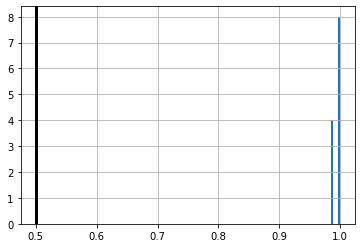

In [21]:
# quick plot of performance
ax = mperf['mean'].hist(bins='auto')
ax.axvline(0.5, color='k', lw=3)

## What about performance on all flanker conditions?

- Another way to test for task compliance is to check the performance on the easiest task conditions.
- ***Question: Did the participant perform above chance on all flanker conditions trials?***

<AxesSubplot:title={'center':'log_rt'}, xlabel='[subj]'>

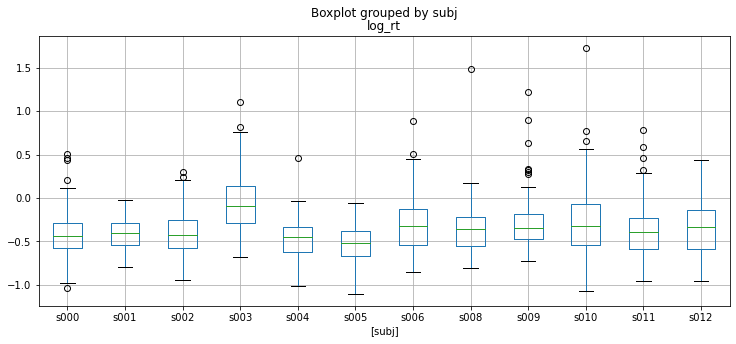

In [22]:
df.boxplot(column=['log_rt'], by=['subj'], figsize=(12,5))

In [23]:
fperf = df.groupby(['subj', 'condition'])['correct'].agg(['sum', 'count', 'mean'])
fperf['binom_pval'] = fperf.apply(lambda x: stats.binom_test(x['sum'], n=x['count'], 
                                                             p=0.5, alternative='two-sided'),
                                  axis=1)
fperf

sum  count      mean    binom_pval
subj condition                                      
s000 congruent     64     64  1.000000  1.084202e-19
     incongruent   63     64  0.984375  7.047314e-18
     mix           52     64  0.812500  4.566611e-07
s001 congruent     64     64  1.000000  1.084202e-19
     incongruent   64     64  1.000000  1.084202e-19
     mix           62     64  0.968750  2.256225e-16
s002 congruent     63     64  0.984375  7.047314e-18
     incongruent   62     64  0.968750  2.256225e-16
     mix           58     64  0.906250  9.029019e-12
s003 congruent     63     64  0.984375  7.047314e-18
     incongruent   64     64  1.000000  1.084202e-19
     mix           64     64  1.000000  1.084202e-19
s004 congruent     64     64  1.000000  1.084202e-19
     incongruent   62     64  0.968750  2.256225e-16
     mix           61     64  0.953125  4.742842e-15
s005 congruent     64     64  1.000000  1.084202e-19
     incongruent   63     64  0.984375  7.047314e-18
     mix           62     64  0.968750  2.256225e-16
s006 congruent     64     64  1.000000  1.084202e-19
     incongruent   63     64  0.984375  7.047314e-18
     mix           63     64  0.984375  7.047314e-18
s008 congruent     63     64  0.984375  7.047314e-18
     incongruent   60     64  0.937500  7.363045e-14
     mix           62     64  0.968750  2.256225e-16
s009 congruent     64     64  1.000000  1.084202e-19
     incongruent   64     64  1.000000  1.084202e-19
     mix           64     64  1.000000  1.084202e-19
s010 congruent     64     64  1.000000  1.084202e-19
     incongruent   63     64  0.984375  7.047314e-18
     mix           64     64  1.000000  1.084202e-19
s011 congruent     64     64  1.000000  1.084202e-19
     incongruent   63     64  0.984375  7.047314e-18
     mix           62     64  0.968750  2.256225e-16
s012 congruent     63     64  0.984375  7.047314e-18
     incongruent   63     64  0.984375  7.047314e-18
     mix           61     64  0.953125  4.742842e-15

## Congruency effect

- The typical congruency effect is that participants show lower accuracy and slower reaction times in the incongruent relative to the congruent conditions
- Let's check that for all our participants!

### Performance by condition

Text(0.5, 0, 'Condition')

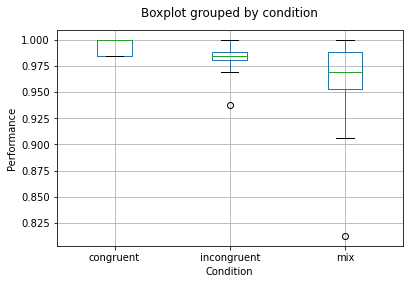

In [24]:
# Let's make a boxplot of the performance values
ax = fperf.boxplot(column='mean', by=['condition'])
ax.set_title('')
ax.set_ylabel('Performance')
ax.set_xlabel('Condition')

### RT by condition

Text(0.5, 0, 'Condition')

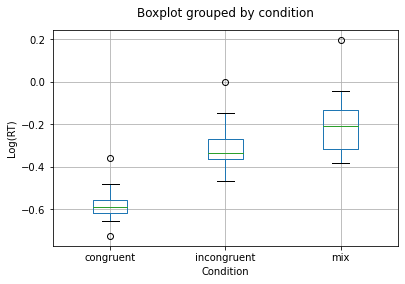

In [25]:
fres = df.groupby(['subj', 'condition'])['log_rt'].mean().reset_index()
ax = fres.boxplot(column='log_rt', by=['condition'])
ax.set_title('')
ax.set_ylabel('Log(RT)')
ax.set_xlabel('Condition')

## Error bars for repeated measures designs

- The box plots above do not actually show us the relationships between the conditions that indicate significance
- We have a repeated-measures design, with different conditions *within* subjects
- Thus, the real comparisons of interest are *within* subjects, not *between* subjects
  - In the box plots, the between-subject variability is masking the within-subject effects!
- To help us visualize the differences more-accurately, we can calculate within-subject corrected error bars
  - All this entails is removing the within-subject mean across conditions before calculating error

In [27]:
# some folks wrote a useful script for calculating these for us!
from ci_within import ci_within

In [28]:
# get the error corrected by condition and whether they got it correct
res = ci_within(df, indexvar='subj', 
                withinvars=['condition', 'correct'], 
                measvar='log_rt')
res

mean       std       sem        ci  len
condition   correct                                             
congruent   False   -0.532124  0.083908  0.041954  0.133516    4
            True    -0.576729  0.188111  0.006806  0.013360  764
incongruent False   -0.583447  0.352288  0.094153  0.203405   14
            True    -0.292329  0.221637  0.008072  0.015845  754
mix         False   -0.348334  0.265820  0.046273  0.094256   33
            True    -0.190375  0.264937  0.009772  0.019185  735

## Unstacking and Resetting Index

- After a group-by, we often need to pivot the data so that it has the right indices for plotting
- The `unstack` command takes a multi-level index and moves one of the row indices to a column
- Here we'll move the `correct` row indicator to be a column indicator
- Calling `reset_index` will fill in the values in all the index columns and add in an overall index.

In [29]:
# must unstack and reset index to plot properly
res.unstack().reset_index()

condition      mean                 std                 sem  \
correct                  False      True     False      True     False   
0          congruent -0.532124 -0.576729  0.083908  0.188111  0.041954   
1        incongruent -0.583447 -0.292329  0.352288  0.221637  0.094153   
2                mix -0.348334 -0.190375  0.265820  0.264937  0.046273   

                         ci             len       
correct      True     False      True False True  
0        0.006806  0.133516  0.013360     4  764  
1        0.008072  0.203405  0.015845    14  754  
2        0.009772  0.094256  0.019185    33  735

Text(0, 0.5, 'Log(RT)')

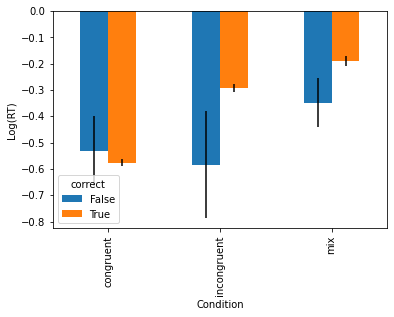

In [30]:
# plot the results
ax = res.unstack().reset_index().plot(x='condition', y='mean', yerr='ci', kind="bar")
#ax.get_legend().remove()
ax.set_xlabel('Condition')
ax.set_ylabel('Log(RT)')

## Regression and beyond!

- This sure looks significant, but we need to build a regression to test all these factors

![](https://scipy-lectures.org/_images/math/8c27948834377cd91a6907f91d1f87acb32f1817.png)

- Here `y` is the dependent variable and `x` is the independent variable(s).
- This is also often called *endogenous* and *exogenous*.

## Statsmodels allows us to specify regressions as formulas

- There are many ways to fit regression models that often depend on your dependent data
  - e.g., ordinary least squares vs. logistic regression

In [31]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

### Question: Are there differences in accuracy between conditions?

In [32]:
# first we need to get summary values for each subj
sum_df = df.groupby(['subj', 'condition'])['correct'].mean().reset_index()
sum_df

,subj,condition,correct
0,s000,congruent,1.000000
1,s000,incongruent,0.984375
2,s000,mix,0.812500
3,s001,congruent,1.000000
4,s001,incongruent,1.000000
5,s001,mix,0.968750
6,s002,congruent,0.984375
7,s002,incongruent,0.968750
8,s002,mix,0.906250
9,s003,congruent,0.984375


In [33]:
# build a least squares regression
model = smf.ols("correct ~ condition", sum_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                correct   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     4.245
Date:                Thu, 28 Oct 2021   Prob (F-statistic):             0.0229
Time:                        13:01:40   Log-Likelihood:                 74.117
No. Observations:                  36   AIC:                            -142.2
Df Residuals:                      33   BIC:                            -137.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.9948      0.009    106.854      0.000       0.976       1.014
condition[T.incongruent]    -0.0130      0.013     -0.989      0.330      -0.040       0.014
condition[T.mix]            -0.0378      0.013     -2.868      0.007      -0.065      -0.011
==============================================================================
Omnibus:                       46.056   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.403
Skew:                          -2.795   Prob(JB):                     2.53e-50
Kurtosis:                      14.001   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Question: Are there differences in RTs between conditions?

In [34]:
# first we need to get summary values for each subj
sum_df = df.groupby(['subj', 'condition', 'correct'])['log_rt'].mean().reset_index()
sum_df

,subj,condition,correct,log_rt
0,s000,congruent,True,-0.574791
1,s000,incongruent,False,-0.901858
2,s000,incongruent,True,-0.384244
3,s000,mix,False,-0.345643
4,s000,mix,True,-0.306438
5,s001,congruent,True,-0.540406
6,s001,incongruent,True,-0.351186
7,s001,mix,False,-0.365017
8,s001,mix,True,-0.325086
9,s002,congruent,False,-0.495000


#### Full model with interaction

log_rt ~ condition + correct + condition*correct + intercept + noise

In [35]:
# build a linear regression of the full model
m0 = smf.ols("log_rt ~ condition * correct", sum_df).fit()
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_rt   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     6.949
Date:                Thu, 28 Oct 2021   Prob (F-statistic):           4.91e-05
Time:                        13:01:45   Log-Likelihood:                 15.642
No. Observations:                  58   AIC:                            -19.28
Df Residuals:                      52   BIC:                            -6.921
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -0.4708      0.098     -4.825      0.000      -0.667      -0.275
condition[T.incongruent]                    -0.1006      0.117     -0.858      0.395      -0.336       0.135
condition[T.mix]                             0.0841      0.117      0.717      0.476      -0.151       0.319
correct[T.True]                             -0.1061      0.113     -0.941      0.351      -0.332       0.120
condition[T.incongruent]:correct[T.True]     0.3853      0.142      2.718      0.009       0.101       0.670
condition[T.mix]:correct[T.True]             0.3013      0.142      2.126      0.038       0.017       0.586
==============================================================================
Omnibus:                       17.841   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.549
Skew:                           0.874   Prob(JB):                     7.02e-09
Kurtosis:                       6.533   Cond. No.                         14.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
sm.stats.anova_lm(m0, typ=2)

,sum_sq,df,F,PR(>F)
condition,0.820911,2.0,10.778665,0.000121
correct,0.338998,1.0,8.902159,0.004331
condition:correct,0.291900,2.0,3.832678,0.028010
Residual,1.980180,52.0,NaN,NaN


#### Model with only correct items

In [37]:
sum_df = df.loc[df['correct']].groupby(['subj', 'condition'])['log_rt'].mean().reset_index()
sum_df

,subj,condition,log_rt
0,s000,congruent,-0.574791
1,s000,incongruent,-0.384244
2,s000,mix,-0.306438
3,s001,congruent,-0.540406
4,s001,incongruent,-0.351186
5,s001,mix,-0.325086
6,s002,congruent,-0.617909
7,s002,incongruent,-0.332117
8,s002,mix,-0.260345
9,s003,congruent,-0.361925


In [38]:
m2 = smf.ols("log_rt ~ condition", sum_df).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_rt   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     28.54
Date:                Thu, 28 Oct 2021   Prob (F-statistic):           6.37e-08
Time:                        13:01:48   Log-Likelihood:                 24.035
No. Observations:                  36   AIC:                            -42.07
Df Residuals:                      33   BIC:                            -37.32
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.5768      0.037    -15.415      0.000      -0.653      -0.501
condition[T.incongruent]     0.2847      0.053      5.380      0.000       0.177       0.392
condition[T.mix]             0.3854      0.053      7.283      0.000       0.278       0.493
==============================================================================
Omnibus:                       11.209   Durbin-Watson:                   1.021
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               10.584
Skew:                           1.119   Prob(JB):                      0.00503
Kurtosis:                       4.431   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Conclusion

- We see a robust congruency effect whereby:
  - Incongruent/Mixed trials have lower performance than congruent
  - *Correct* incongruent/mixed trials are much slower than *incorrect*
  - i.e., participants make "fast" errors

## Assignment before next class

- We will some recognition tasks to run based on the tasks developed for class
- This will be due on ***Wednesday*** next week so we have time to compile the data

### See you next week!!!